In [1]:
#code for the lumen. We gonna read the otulumen and from that get the abundances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
abu0=pd.read_csv("otulumen.csv")
tx0=pd.read_csv("lumentax.csv")
dfA=pd.DataFrame(abu0)
dfT=pd.DataFrame(tx0)
#uses the ID on the dfT dataframe (left), and find it on the df dataframe (right)#
#the file tax abundance contains all the information: full taxonomy and the values of each sample#
tax_abundance=pd.merge(left=dfT,right=dfA,left_on='ID', right_on='ID')
#dfA=tax_abundance.set_index('ID').T-->convenient way to transpose keeping the ID in the header
#list the name of columns in the dataframe df
#list(df.columns.values)
#now we drop the samples that have a total abundance <7000
modData=tax_abundance
from pandas.api.types import is_numeric_dtype

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        if sum(modData[column]) < 7000:
           modData.drop([column], axis=1, inplace=True)
#----------------------------
#-----now we normalize the samples in such a way each of them add to 1

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        modData[column]=modData[column]/modData[column].sum()
#------------verification, we can comment this out
#for column in modData.columns[8:]:
#     if is_numeric_dtype(modData[column]):
#        ls=modData.sum(axis=0,skipna=True)
#        #check if everybody is normalized to one
#nd=modData.sum(numeric_only =True )
#for x in range(len(nd)):
#    print(nd[x]),
#-----------------------
#----now we tally the samples by desired tax level
#phylumData= modData.groupby("Phylum")["Order"].count()--tells us how many orders in the groups of phylum
phylumData=modData.groupby("Phylum").sum().reset_index()

In [2]:
phylumData

,Phylum,A1.si.lum,A10.si.lum,A11.si.lum,A13.si.lum,A16.si.lum,A18.si.lum,A2.si.lum,A7.si.lum,C1.si.lum,...,X10.si.lum,X11.si.lum,X12.si.lum,X13.si.lum,X15.si.lum,X16.si.lum,X18.si.lum,X5.si.lum,X7.si.lum,X8.si.lum
0,Actinobacteria,0.000000,0.024178,0.072575,0.000584,0.000000,0.000203,0.000117,0.047726,0.003896,...,0.000522,0.000077,0.001611,0.015712,0.007915,0.002073,0.003161,0.002260,0.001510,0.003726
1,Bacteroidetes,0.551724,0.592666,0.615397,0.581469,0.779028,0.896412,0.928342,0.668264,0.891549,...,0.441520,0.524505,0.845746,0.733419,0.510284,0.503817,0.791031,0.803536,0.866577,0.784249
2,Cyanobacteria,0.000124,0.000189,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000378,0.001683,0.004278,0.001376,0.000930,0.002980,0.002981
3,Deferribacteres,0.000093,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001042,0.000000,0.000966,0.000362,0.000149,0.000000,0.000000,0.000000
4,Firmicutes,0.074847,0.295150,0.261347,0.114404,0.023190,0.103182,0.061948,0.229331,0.077920,...,0.368682,0.416435,0.092477,0.086267,0.414615,0.276820,0.185543,0.117506,0.040289,0.099163
5,Fusobacteria,0.000000,0.000000,0.003143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Proteobacteria,0.372408,0.085167,0.047538,0.303397,0.197326,0.000203,0.001813,0.054679,0.025643,...,0.189066,0.058248,0.058272,0.163771,0.049361,0.100072,0.016955,0.036422,0.022290,0.080133
7,Tenericutes,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000585,0.000000,0.000213,...,0.000000,0.000425,0.000000,0.000000,0.001870,0.000790,0.000855,0.000000,0.000000,0.000000
8,Verrucomicrobia,0.000000,0.002650,0.000000,0.000146,0.000359,0.000000,0.006552,0.000000,0.000779,...,0.000209,0.000309,0.000853,0.000453,0.013306,0.111788,0.000930,0.039346,0.066354,0.029749


In [3]:
#iloc[[i],[j]] gives u the i-row and j-column
#tax_abundance.iloc[[1],[8]]

In [209]:
modData['A1.si.lum'].sum()

1.0

In [60]:
modData.loc[:,'A1.si.lum':'A11.si.lum']

,A1.si.lum,A10.si.lum,A11.si.lum
0,0.021203,0.003549,0.000993
1,0.046214,0.023799,0.005074
2,0.022194,0.029241,0.074229
3,0.020275,0.014620,0.003088
4,0.154770,0.061982,0.058953
...,...,...,...
833,0.000000,0.000000,0.000000
834,0.000000,0.000000,0.000000
835,0.000000,0.000000,0.000000
836,0.000000,0.000000,0.000000


In [65]:
phylumData

,Phylum,A1.si.lum,A10.si.lum,A11.si.lum,A13.si.lum,A16.si.lum,A18.si.lum,A2.si.lum,A7.si.lum,C1.si.lum,...,X10.si.lum,X11.si.lum,X12.si.lum,X13.si.lum,X15.si.lum,X16.si.lum,X18.si.lum,X5.si.lum,X7.si.lum,X8.si.lum
0,Actinobacteria,0.000000,0.024178,0.072575,0.000584,0.000000,0.000203,0.000117,0.047726,0.003896,...,0.000522,0.000077,0.001611,0.015712,0.007915,0.002073,0.003161,0.002260,0.001510,0.003726
1,Bacteroidetes,0.551724,0.592666,0.615397,0.581469,0.779028,0.896412,0.928342,0.668264,0.891549,...,0.441520,0.524505,0.845746,0.733419,0.510284,0.503817,0.791031,0.803536,0.866577,0.784249
2,Cyanobacteria,0.000124,0.000189,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000378,0.001683,0.004278,0.001376,0.000930,0.002980,0.002981
3,Deferribacteres,0.000093,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001042,0.000000,0.000966,0.000362,0.000149,0.000000,0.000000,0.000000
4,Firmicutes,0.074847,0.295150,0.261347,0.114404,0.023190,0.103182,0.061948,0.229331,0.077920,...,0.368682,0.416435,0.092477,0.086267,0.414615,0.276820,0.185543,0.117506,0.040289,0.099163
5,Fusobacteria,0.000000,0.000000,0.003143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Proteobacteria,0.372408,0.085167,0.047538,0.303397,0.197326,0.000203,0.001813,0.054679,0.025643,...,0.189066,0.058248,0.058272,0.163771,0.049361,0.100072,0.016955,0.036422,0.022290,0.080133
7,Tenericutes,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000585,0.000000,0.000213,...,0.000000,0.000425,0.000000,0.000000,0.001870,0.000790,0.000855,0.000000,0.000000,0.000000
8,Verrucomicrobia,0.000000,0.002650,0.000000,0.000146,0.000359,0.000000,0.006552,0.000000,0.000779,...,0.000209,0.000309,0.000853,0.000453,0.013306,0.111788,0.000930,0.039346,0.066354,0.029749


In [3]:
phylumData['A10.si.lum'].sum()

1.0000000000000002

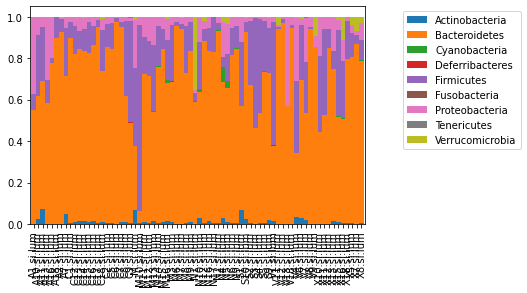

In [83]:
#now we select the columns to plot; the horizontal slices will follow the Phylum, so we set the index Phylum 
#and do a transpose
amp=phylumData[ ['Phylum']+ list(phylumData.loc[:,'A1.si.lum':'X8.si.lum'])].set_index('Phylum').T
amp.plot(kind='bar',stacked=True,width=1).legend(bbox_to_anchor=(1.1, 1.0))

In [248]:
phylumData

,Phylum,A1.si.lum,A10.si.lum,A11.si.lum,A13.si.lum,A16.si.lum,A18.si.lum,A2.si.lum,A7.si.lum,C1.si.lum,...,X10.si.lum,X11.si.lum,X12.si.lum,X13.si.lum,X15.si.lum,X16.si.lum,X18.si.lum,X5.si.lum,X7.si.lum,X8.si.lum
0,Actinobacteria,0.000000,0.024178,0.072575,0.000584,0.000000,0.000203,0.000117,0.047726,0.003896,...,0.000522,0.000077,0.001611,0.015712,0.007915,0.002073,0.003161,0.002260,0.001510,0.003726
1,Bacteroidetes,0.551724,0.592666,0.615397,0.581469,0.779028,0.896412,0.928342,0.668264,0.891549,...,0.441520,0.524505,0.845746,0.733419,0.510284,0.503817,0.791031,0.803536,0.866577,0.784249
2,Cyanobacteria,0.000124,0.000189,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000378,0.001683,0.004278,0.001376,0.000930,0.002980,0.002981
3,Deferribacteres,0.000093,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001042,0.000000,0.000966,0.000362,0.000149,0.000000,0.000000,0.000000
4,Firmicutes,0.074847,0.295150,0.261347,0.114404,0.023190,0.103182,0.061948,0.229331,0.077920,...,0.368682,0.416435,0.092477,0.086267,0.414615,0.276820,0.185543,0.117506,0.040289,0.099163
5,Fusobacteria,0.000000,0.000000,0.003143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Proteobacteria,0.372408,0.085167,0.047538,0.303397,0.197326,0.000203,0.001813,0.054679,0.025643,...,0.189066,0.058248,0.058272,0.163771,0.049361,0.100072,0.016955,0.036422,0.022290,0.080133
7,Tenericutes,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000585,0.000000,0.000213,...,0.000000,0.000425,0.000000,0.000000,0.001870,0.000790,0.000855,0.000000,0.000000,0.000000
8,Verrucomicrobia,0.000000,0.002650,0.000000,0.000146,0.000359,0.000000,0.006552,0.000000,0.000779,...,0.000209,0.000309,0.000853,0.000453,0.013306,0.111788,0.000930,0.039346,0.066354,0.029749


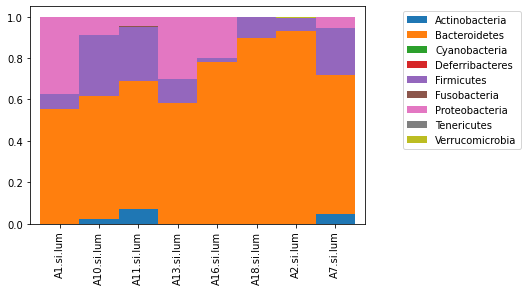

In [4]:
#now we select the columns to plot; the horizontal slices will follow the Phylum, so we set the index Phylum 
#and do a transpose
amp=phylumData[ ['Phylum']+ list(phylumData.loc[:,'A1.si.lum':'A7.si.lum'])].set_index('Phylum').T
amp.plot(kind='bar',stacked=True, width=1).legend(bbox_to_anchor=(1.1, 1.0))

In [263]:
#takes only the columns form the dataset
phylumData.iloc[:,[0]].T

,0,1,2,3,4,5,6,7,8
Phylum,Actinobacteria,Bacteroidetes,Cyanobacteria,Deferribacteres,Firmicutes,Fusobacteria,Proteobacteria,Tenericutes,Verrucomicrobia


In [5]:
def n(i):
    return phylumData.iloc[:,[i]].values
#phylumData.iloc[:,[1]]

In [40]:
n(1)

array([[0.00000000e+00],
       [5.51724138e-01],
       [1.23816009e-04],
       [9.28620071e-05],
       [7.48467777e-02],
       [0.00000000e+00],
       [3.72407602e-01],
       [8.04804061e-04],
       [0.00000000e+00]])

In [45]:
phylumData.iloc[:,[1]]

,A1.si.lum
0,0.000000
1,0.551724
2,0.000124
3,0.000093
4,0.074847
5,0.000000
6,0.372408
7,0.000805
8,0.000000


In [16]:
phylumData

,Phylum,A1.si.lum,A10.si.lum,A11.si.lum,A13.si.lum,A16.si.lum,A18.si.lum,A2.si.lum,A7.si.lum,C1.si.lum,...,X10.si.lum,X11.si.lum,X12.si.lum,X13.si.lum,X15.si.lum,X16.si.lum,X18.si.lum,X5.si.lum,X7.si.lum,X8.si.lum
0,Actinobacteria,0.000000,0.024178,0.072575,0.000584,0.000000,0.000203,0.000117,0.047726,0.003896,...,0.000522,0.000077,0.001611,0.015712,0.007915,0.002073,0.003161,0.002260,0.001510,0.003726
1,Bacteroidetes,0.551724,0.592666,0.615397,0.581469,0.779028,0.896412,0.928342,0.668264,0.891549,...,0.441520,0.524505,0.845746,0.733419,0.510284,0.503817,0.791031,0.803536,0.866577,0.784249
2,Cyanobacteria,0.000124,0.000189,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000378,0.001683,0.004278,0.001376,0.000930,0.002980,0.002981
3,Deferribacteres,0.000093,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001042,0.000000,0.000966,0.000362,0.000149,0.000000,0.000000,0.000000
4,Firmicutes,0.074847,0.295150,0.261347,0.114404,0.023190,0.103182,0.061948,0.229331,0.077920,...,0.368682,0.416435,0.092477,0.086267,0.414615,0.276820,0.185543,0.117506,0.040289,0.099163
5,Fusobacteria,0.000000,0.000000,0.003143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Proteobacteria,0.372408,0.085167,0.047538,0.303397,0.197326,0.000203,0.001813,0.054679,0.025643,...,0.189066,0.058248,0.058272,0.163771,0.049361,0.100072,0.016955,0.036422,0.022290,0.080133
7,Tenericutes,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000585,0.000000,0.000213,...,0.000000,0.000425,0.000000,0.000000,0.001870,0.000790,0.000855,0.000000,0.000000,0.000000
8,Verrucomicrobia,0.000000,0.002650,0.000000,0.000146,0.000359,0.000000,0.006552,0.000000,0.000779,...,0.000209,0.000309,0.000853,0.000453,0.013306,0.111788,0.000930,0.039346,0.066354,0.029749


In [14]:
phylumData.shape

(9, 73)

In [4]:
ampMat=phylumData[list(phylumData.loc[:,'A1.si.lum':'A7.si.lum'])]
ampMat

,A1.si.lum,A10.si.lum,A11.si.lum,A13.si.lum,A16.si.lum,A18.si.lum,A2.si.lum,A7.si.lum
0,0.000000,0.024178,0.072575,0.000584,0.000000,0.000203,0.000117,0.047726
1,0.551724,0.592666,0.615397,0.581469,0.779028,0.896412,0.928342,0.668264
2,0.000124,0.000189,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000
3,0.000093,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000
4,0.074847,0.295150,0.261347,0.114404,0.023190,0.103182,0.061948,0.229331
5,0.000000,0.000000,0.003143,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.372408,0.085167,0.047538,0.303397,0.197326,0.000203,0.001813,0.054679
7,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000585,0.000000
8,0.000000,0.002650,0.000000,0.000146,0.000359,0.000000,0.006552,0.000000


In [5]:
corrampMat=ampMat.corr()
print(corrampMat)

            A1.si.lum  A10.si.lum  A11.si.lum  A13.si.lum  A16.si.lum  \
A1.si.lum    1.000000    0.801829    0.780278    0.989262    0.926705   
A10.si.lum   0.801829    1.000000    0.992066    0.878639    0.883667   
A11.si.lum   0.780278    0.992066    1.000000    0.861868    0.895024   
A13.si.lum   0.989262    0.878639    0.861868    1.000000    0.959106   
A16.si.lum   0.926705    0.883667    0.895024    0.959106    1.000000   
A18.si.lum   0.803104    0.928400    0.951430    0.873255    0.961197   
A2.si.lum    0.805192    0.909891    0.935956    0.871569    0.965954   
A7.si.lum    0.809889    0.987319    0.996181    0.886232    0.927556   

            A18.si.lum  A2.si.lum  A7.si.lum  
A1.si.lum     0.803104   0.805192   0.809889  
A10.si.lum    0.928400   0.909891   0.987319  
A11.si.lum    0.951430   0.935956   0.996181  
A13.si.lum    0.873255   0.871569   0.886232  
A16.si.lum    0.961197   0.965954   0.927556  
A18.si.lum    1.000000   0.998726   0.972880  
A2.si.lum    

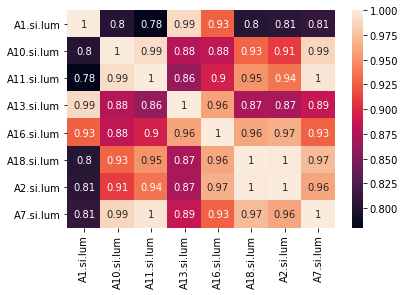

In [6]:
import seaborn as sn
sn.heatmap(corrampMat, annot=True)
plt.show()

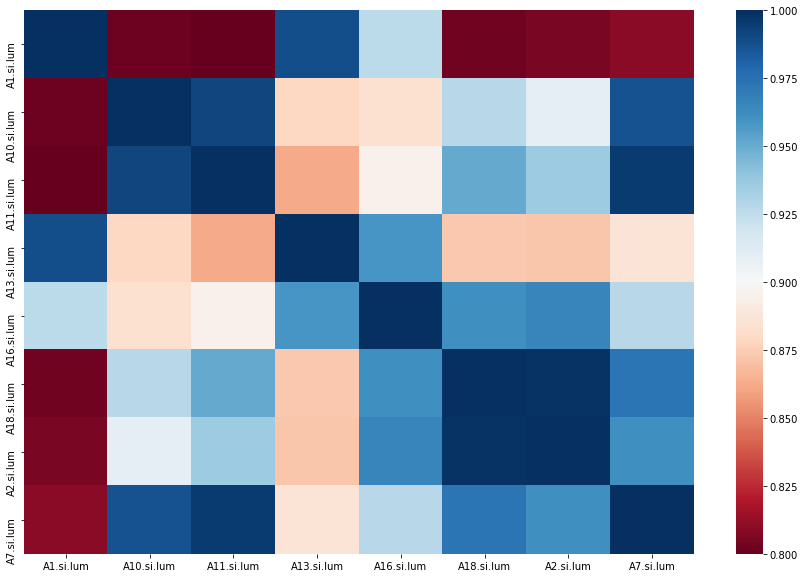

In [7]:
plt.figure(figsize=(15,10))
data=ampMat
correlations = data.corr()
#turn annot=True to show the values in each square
sn.heatmap(round(correlations,3), cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=.8, vmax=1);

array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

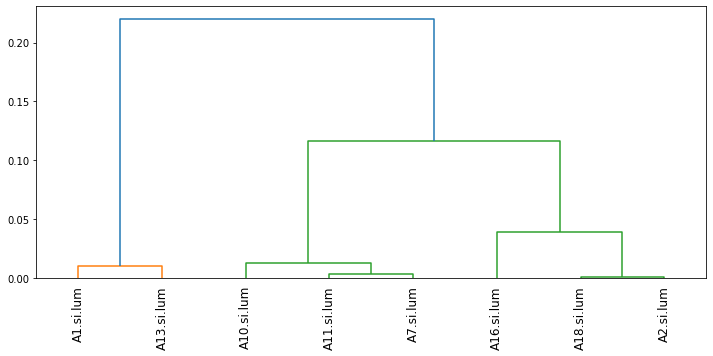

In [23]:
#part of hierarchical Clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(ampMat.corr())
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=data.columns, orientation='top', 
           leaf_rotation=90);
# Clusterize the data
threshold = 0.9
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

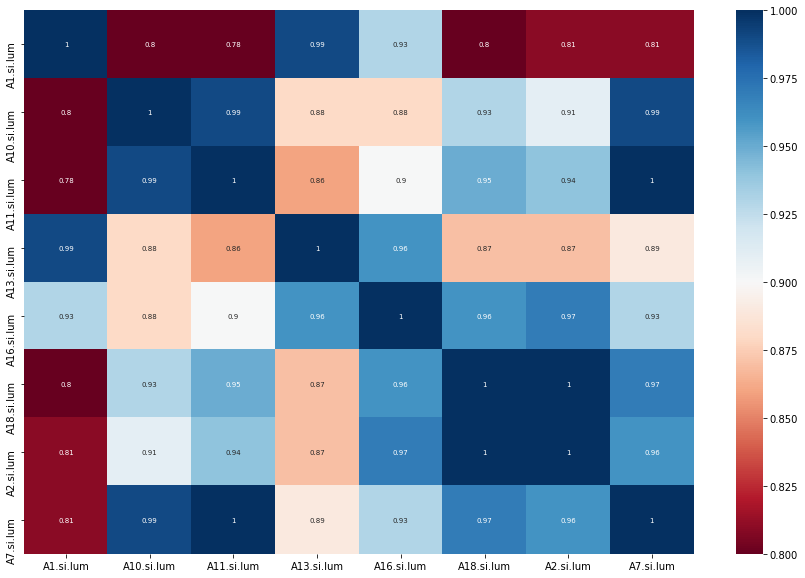

In [15]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)
        
plt.figure(figsize=(15,10))
correlations = clustered.corr()
sn.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.8, vmax=1);       

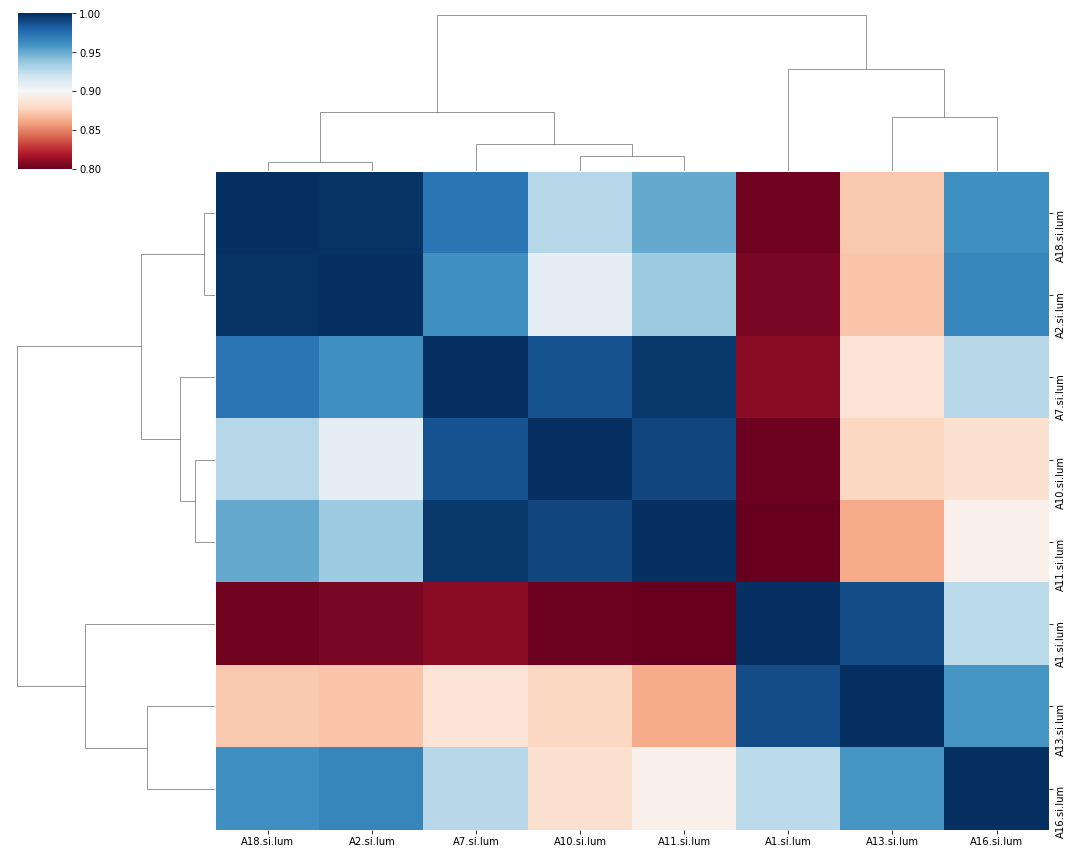

In [16]:
sn.clustermap(correlations, method="complete", cmap='RdBu', annot=False, 
               annot_kws={"size": 7}, vmin=0.8, vmax=1, figsize=(15,12));

In [290]:
list1=phylumData.iloc[:,[0]].T

In [292]:
list1

,0,1,2,3,4,5,6,7,8
Phylum,Actinobacteria,Bacteroidetes,Cyanobacteria,Deferribacteres,Firmicutes,Fusobacteria,Proteobacteria,Tenericutes,Verrucomicrobia


In [273]:
color_list=['b','g','r','c','m','k','p','o','n']

In [284]:
d2c = dict(zip(list1, color_list))

In [285]:
d2c

{0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'k', 6: 'p', 7: 'o', 8: 'n'}

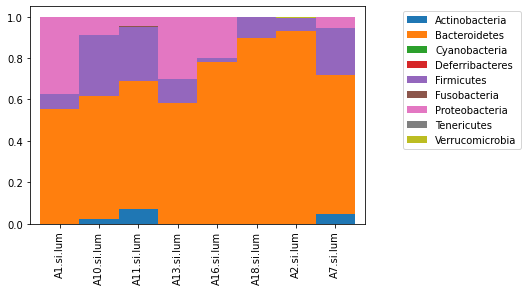

In [289]:
amp.plot(kind='bar',stacked=True, width=1,color=map(d2c.get,amp)).legend(bbox_to_anchor=(1.1, 1.0))

In [281]:
color=map(d2c.get,amp.columns)

In [282]:
color

In [283]:
d2c.get

<function dict.get>